In [20]:
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import NMF

from random import sample

import copy
from functions import plotsigs, cosine_perm, simulate_counts
from AAUtoSig_init import AAUtoSig, train_AAUtoSig
from optuna_opt import optuna_tune
from torch import optim

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [15]:
def split_data(data, frac_1, frac_2):
  x_tuning = data.sample(frac = frac_1)
  data_new = data.drop(x_tuning.index)
  x_train = data_new.sample(frac=frac_2)
  x_val = data.drop(x_train.index)
  return x_tuning, x_train, x_val

# NMF performance

In [16]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  
  cos_NMF = cosine_perm(true_sigs.to_numpy().transpose(), signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [22]:
def out_errorAE(tuning_df, train_df, validation_df, nsigs, true_sigs):
  params = optuna_tune(tuning_df, nsigs)
  lr = params['lr']
  batch_size = params['batch_size']
  optimizer_name = params['optimizer']
  model = AAUtoSig(dim1 = nsigs)

  # Validation using MSE Loss function
  loss_function = torch.nn.MSELoss(reduction='mean')

  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

                              
  train_AAUtoSig(epochs = 500, 
                model = model, 
                x_train = train_df, 
                loss_function = loss_function, 
                optimizer = optimizer,
                batch_size = int(batch_size)
)

  W = model.dec2.weight.data    
  W_array = W.numpy()

  cos_AE = cosine_perm(true_sigs.to_numpy().transpose(),W_array.transpose())[0]
  cos_mean = np.mean(cos_AE.diagonal())

  x_validation_tensor = torch.tensor(validation_df.values, 
                                      dtype = torch.float32)
  rec = model(x_validation_tensor)
  MSE = (float(loss_function(rec,x_validation_tensor).detach().numpy()))

  return([cos_mean, MSE])

## Performance analysis

In [23]:
def performance_analysis(npatients, nsigs):
  mut_matrix, signatures, _ = simulate_counts(nsigs, npatients, nonlinear=True)
  signatures.drop(signatures.columns[nsigs], axis = 1, inplace = True)
  tuning_data, train_data, validation_data = split_data(mut_matrix.transpose(), 0.3, 0.8)
  return(out_errorNMF(pd.concat([tuning_data, train_data]), validation_data, nsigs, signatures) + out_errorAE(tuning_data, train_data, validation_data, nsigs, signatures))
asd = np.array([performance_analysis(4000, 5) for _ in range(2)])
result = pd.DataFrame(asd)
result.columns = ["cosineNMF", "outNMF", "cosineAE", "outAE"]


q:\AUH-HAEM-FORSK-MutSigDLBCL222\article_1\scripts\AAUtoSig\functions.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs[name] = prod
[I 2022-02-22 15:12:42,148] A new study created in memory with name: no-name-10e9998c-5b52-4a2f-ac77-171551403e71
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-02-22 15:13:46,330] Trial 2 finished with value: 98.64900665283203 and parameters: {'lr': 0.00575526085780963, 'batch_size': 64, 'optimizer': 'SGD'}. B

TypeError: __init__() missing 1 required positional argument: 'dim2'

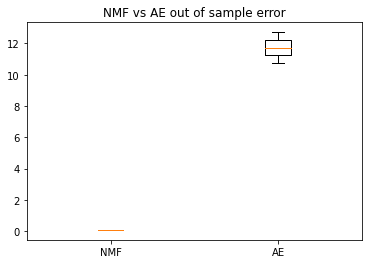

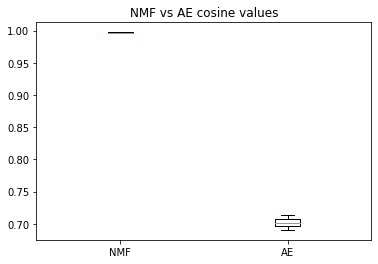

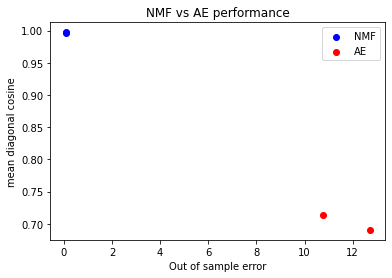

In [ ]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error')
plt.show()

plt.boxplot(result[['cosineNMF', 'cosineAE']],labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values')
plt.show()

plt.scatter(y = result['cosineNMF'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance')
plt.legend()
plt.show()